This notebook is developed for `IS3240 - Advanced Bus Prog in Python` at the City University of Hong Kong

***Group 2 - SpotiPy***

The project aims to perform Python data processing techniques including data collection,cleansing, analytics, visualization on the dataset, and try to formulate a satisfying machine learning model to predict the popularity of newly released mini albums (Single & EP).

# DATA COLLECTION

We tried to collect album data from Spotify API, but failed to do so due to the limit of data requests (only first 1000 albums in each year are available)

Please refer to the other `ipynb file` for the data collection via API module (for reference only)

The dataset is collected from [Kaggle](https://www.kaggle.com/datasets/elemento/music-albums-popularity-prediction?select=train.csv), which contains **all** the albums from 1927 to 2021-09 and their basic information incl.`album name`, `artists`, `release date`, `total tracks`, as well as the first three songs of each album and their special features, incl. `danceability`, `energy`, `acousticness`, `key`, `mode`, `speechiness`, `instrumentalness`, `liveness`, `tempo`, `valence`, and most importantly, our numerial Y variable `popularity score`, range from 1-100. 

Please refer to the [Kaggle](https://www.kaggle.com/datasets/elemento/music-albums-popularity-prediction?select=train.csv) website for more information about the meaning of each IVs. 

# DATA CLEANSING

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from tqdm import tqdm
import seaborn as sns
from collections import Counter
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
total_albums = pd.read_csv("C:/Users/17008/OneDrive - City University of Hong Kong/IS3240 Advanced Bus Prog in Python/Data/album.csv")
total_albums.drop(['id'], axis=1, inplace=True)
total_albums.drop_duplicates(inplace=True)
total_albums

,name,release_date,artists,total_tracks,t_name0,t_name1,t_name2,t_dur0,t_dur1,t_dur2,...,t_val0,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity
0,Ya Solo Eres Mi Ex,2021-09-09,"La Adictiva Banda San José de Mesillas,",7,Ya Solo Eres Mi Ex,La Malagueña,México Lindo y Querido,222133,189133.0,165586.0,...,0.626,0.878,0.833,74.924,126.970,197.836,4.0,3.0,3.0,51
1,Nibiru,2019-11-29,"Ozuna,",18,Nibiru,Hasta Que Salga el Sol,Temporal,158826,188480.0,238293.0,...,0.158,0.598,0.484,173.023,96.042,148.019,4.0,4.0,4.0,67
2,DAMN.,2017-04-14,"Kendrick Lamar,",14,BLOOD.,DNA.,YAH.,118066,185946.0,160293.0,...,0.494,0.422,0.648,156.907,139.913,69.986,4.0,4.0,4.0,81
3,Did I Shave My Legs For This?,1996-01-01,"Deana Carter,",11,I've Loved Enough To Know,We Danced Anyway,Count Me In,203693,202533.0,205373.0,...,0.755,0.651,0.263,120.285,94.054,130.011,4.0,4.0,4.0,53
4,glisten,2018-05-04,"Jeremy Zucker,",4,all the kids are depressed,wildfire,glisten (interlude),169973,163000.0,89106.0,...,0.707,0.426,0.466,103.861,129.170,116.349,4.0,4.0,4.0,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159978,Souvenir,2018-12-15,"Zpextre,",1,Souvenir,NaN,NaN,211152,NaN,NaN,...,0.867,NaN,NaN,166.001,NaN,NaN,4.0,NaN,NaN,26
159980,Ezra,2018-09-17,"Becca VanDerbeck,",1,Ezra,NaN,NaN,174000,NaN,NaN,...,0.160,NaN,NaN,94.350,NaN,NaN,4.0,NaN,NaN,24
159984,No Love,2021-06-03,"YYx2Beatz,",1,No Love,NaN,NaN,157500,NaN,NaN,...,0.447,NaN,NaN,160.022,NaN,NaN,4.0,NaN,NaN,1
159991,ВЫПУСКНИК,2020-06-19,"ФОГЕЛЬ,",1,ВЫПУСКНИК,NaN,NaN,228093,NaN,NaN,...,0.435,NaN,NaN,80.011,NaN,NaN,4.0,NaN,NaN,36


In [3]:
# Filter out all the albums after the release of Jackson 5's first album "Diana Ross Presents The Jackson 5"
total_albums = total_albums.loc[(total_albums['release_date'] >= '1969-12-18')]

# Remove all the albums with tracks greater than 3
albums_less_than_three = total_albums[total_albums.total_tracks <= 3]

albums_less_than_three.head(3)

,name,release_date,artists,total_tracks,t_name0,t_name1,t_name2,t_dur0,t_dur1,t_dur2,...,t_val0,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity
5,IDK You Yet (Live on Piano),2020-06-23,"Alexander 23,",2,IDK You Yet - Live on Piano,IDK You Yet,NaN,234538,184638.0,NaN,...,0.187,0.198,NaN,64.142,76.997,NaN,4.0,1.0,NaN,70
11,Enjoy Enjaami - Spotify Singles (with Dhee fea...,2021-06-21,"DJ Snake, Dhee,",1,Enjoy Enjaami - Spotify Singles (with Dhee fea...,NaN,NaN,167058,NaN,NaN,...,0.641,NaN,NaN,101.968,NaN,NaN,4.0,NaN,NaN,51
16,QVC,2021-04-23,"Skofee,",1,QVC,NaN,NaN,165867,NaN,NaN,...,0.495,NaN,NaN,102.032,NaN,NaN,4.0,NaN,NaN,1


In [4]:
albums_less_than_three.drop(['release_date','t_name0','t_name1','t_name2'], axis=1, inplace=True)
albums_less_than_three

C:\Users\17008\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,name,artists,total_tracks,t_dur0,t_dur1,t_dur2,t_dance0,t_dance1,t_dance2,t_energy0,...,t_val0,t_val1,t_val2,t_tempo0,t_tempo1,t_tempo2,t_sig0,t_sig1,t_sig2,popularity
5,IDK You Yet (Live on Piano),"Alexander 23,",2,234538,184638.0,NaN,0.371,0.648,NaN,0.18300,...,0.1870,0.1980,NaN,64.142,76.997,NaN,4.0,1.0,NaN,70
11,Enjoy Enjaami - Spotify Singles (with Dhee fea...,"DJ Snake, Dhee,",1,167058,NaN,NaN,0.815,NaN,NaN,0.68800,...,0.6410,NaN,NaN,101.968,NaN,NaN,4.0,NaN,NaN,51
16,QVC,"Skofee,",1,165867,NaN,NaN,0.750,NaN,NaN,0.62100,...,0.4950,NaN,NaN,102.032,NaN,NaN,4.0,NaN,NaN,1
17,Quoted,"Gerald Kenneth Turner,",2,208000,204000.0,NaN,0.226,0.147,NaN,0.04980,...,0.0324,0.0341,NaN,137.589,75.441,NaN,5.0,4.0,NaN,52
22,Box Fan Sound,"Tmsoft’s White Noise Sleep Sounds,",1,589971,NaN,NaN,0.000,NaN,NaN,0.00002,...,0.0000,NaN,NaN,0.000,NaN,NaN,0.0,NaN,NaN,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159978,Souvenir,"Zpextre,",1,211152,NaN,NaN,0.596,NaN,NaN,0.92100,...,0.8670,NaN,NaN,166.001,NaN,NaN,4.0,NaN,NaN,26
159980,Ezra,"Becca VanDerbeck,",1,174000,NaN,NaN,0.559,NaN,NaN,0.49900,...,0.1600,NaN,NaN,94.350,NaN,NaN,4.0,NaN,NaN,24
159984,No Love,"YYx2Beatz,",1,157500,NaN,NaN,0.796,NaN,NaN,0.16100,...,0.4470,NaN,NaN,160.022,NaN,NaN,4.0,NaN,NaN,1
159991,ВЫПУСКНИК,"ФОГЕЛЬ,",1,228093,NaN,NaN,0.782,NaN,NaN,0.45300,...,0.4350,NaN,NaN,80.011,NaN,NaN,4.0,NaN,NaN,36


In [5]:
# mean of every feature
albums_less_than_three['mean_dur'] = albums_less_than_three[['t_dur0','t_dur1','t_dur2']].mean(axis=1)
albums_less_than_three['mean_dance'] = albums_less_than_three[['t_dance0','t_dance1','t_dance2']].mean(axis=1)
albums_less_than_three['mean_energy'] = albums_less_than_three[['t_energy0','t_energy1','t_energy2']].mean(axis=1)
albums_less_than_three['mean_key'] = albums_less_than_three[['t_key0','t_key1','t_key2']].mean(axis=1)
albums_less_than_three['mean_mode'] = albums_less_than_three[['t_mode0','t_mode1','t_mode2']].mean(axis=1)
albums_less_than_three['mean_speech'] = albums_less_than_three[['t_speech0','t_speech1','t_speech2']].mean(axis=1)
albums_less_than_three['mean_acous'] = albums_less_than_three[['t_acous0','t_acous1','t_acous2']].mean(axis=1)
albums_less_than_three['mean_ins'] = albums_less_than_three[['t_ins0','t_ins1','t_ins2']].mean(axis=1)
albums_less_than_three['mean_live'] = albums_less_than_three[['t_live0','t_live1','t_live2']].mean(axis=1)
albums_less_than_three['mean_val'] = albums_less_than_three[['t_val0','t_val1','t_val2']].mean(axis=1)
albums_less_than_three['mean_tempo'] = albums_less_than_three[['t_tempo0','t_tempo1','t_tempo2']].mean(axis=1)
albums_less_than_three['mean_sig'] = albums_less_than_three[['t_sig0','t_sig1','t_sig2']].mean(axis=1)

# max of every features
albums_less_than_three['max_dur'] = albums_less_than_three[['t_dur0','t_dur1','t_dur2']].max(axis=1)
albums_less_than_three['max_dance'] = albums_less_than_three[['t_dance0','t_dance1','t_dance2']].max(axis=1)
albums_less_than_three['max_energy'] = albums_less_than_three[['t_energy0','t_energy1','t_energy2']].max(axis=1)
albums_less_than_three['max_key'] = albums_less_than_three[['t_key0','t_key1','t_key2']].max(axis=1)
albums_less_than_three['max_mode'] = albums_less_than_three[['t_mode0','t_mode1','t_mode2']].max(axis=1)
albums_less_than_three['max_speech'] = albums_less_than_three[['t_speech0','t_speech1','t_speech2']].max(axis=1)
albums_less_than_three['max_acous'] = albums_less_than_three[['t_acous0','t_acous1','t_acous2']].max(axis=1)
albums_less_than_three['max_ins'] = albums_less_than_three[['t_ins0','t_ins1','t_ins2']].max(axis=1)
albums_less_than_three['max_live'] = albums_less_than_three[['t_live0','t_live1','t_live2']].max(axis=1)
albums_less_than_three['max_val'] = albums_less_than_three[['t_val0','t_val1','t_val2']].max(axis=1)
albums_less_than_three['max_tempo'] = albums_less_than_three[['t_tempo0','t_tempo1','t_tempo2']].max(axis=1)
albums_less_than_three['max_sig'] = albums_less_than_three[['t_sig0','t_sig1','t_sig2']].max(axis=1)

# drop all the columns with features of a single track
albums_less_than_three.drop(['t_dur0','t_dur1','t_dur2','t_dance0','t_dance1','t_dance2','t_energy0','t_energy1','t_energy2',
                            't_key0','t_key1','t_key2','t_mode0','t_mode1','t_mode2','t_speech0','t_speech1','t_speech2',
                             't_acous0','t_acous1','t_acous2','t_ins0','t_ins1','t_ins2','t_live0','t_live1','t_live2',
                            't_val0','t_val1','t_val2','t_tempo0','t_tempo1','t_tempo2','t_sig0','t_sig1','t_sig2'], axis=1, inplace=True)

albums_less_than_three.dropna(inplace=True)
albums_less_than_three.head(3)

<ipython-input-5-6047d54eff4d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albums_less_than_three['mean_dur'] = albums_less_than_three[['t_dur0','t_dur1','t_dur2']].mean(axis=1)
<ipython-input-5-6047d54eff4d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albums_less_than_three['mean_dance'] = albums_less_than_three[['t_dance0','t_dance1','t_dance2']].mean(axis=1)
<ipython-input-5-6047d54eff4d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

<ipython-input-5-6047d54eff4d>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albums_less_than_three.dropna(inplace=True)


,name,artists,total_tracks,popularity,mean_dur,mean_dance,mean_energy,mean_key,mean_mode,mean_speech,...,max_energy,max_key,max_mode,max_speech,max_acous,max_ins,max_live,max_val,max_tempo,max_sig
5,IDK You Yet (Live on Piano),"Alexander 23,",2,70,209588.0,0.5095,0.2455,0.5,1.0,0.0608,...,0.308,1.0,1.0,0.0816,0.92300,0.077400,0.335,0.198,76.997,4.0
11,Enjoy Enjaami - Spotify Singles (with Dhee fea...,"DJ Snake, Dhee,",1,51,167058.0,0.8150,0.6880,0.0,1.0,0.0659,...,0.688,0.0,1.0,0.0659,0.00159,0.000004,0.111,0.641,101.968,4.0
16,QVC,"Skofee,",1,1,165867.0,0.7500,0.6210,2.0,1.0,0.0312,...,0.621,2.0,1.0,0.0312,0.04130,0.000189,0.140,0.495,102.032,4.0


--------------

# DATA ANALYSIS - Data Exploration

## 1. Congrats to the TOP 5 Popular Albums!

### *I love Ed Sheeran!!!*

In [6]:
albums_less_than_three['popularity'].nlargest(n=5)

3890    90
76      89
1271    88
3512    86
4547    86
Name: popularity, dtype: int64

## 2. Distribution of popularity scores of all the mini albums

array([[<AxesSubplot:title={'center':'popularity'}>]], dtype=object)

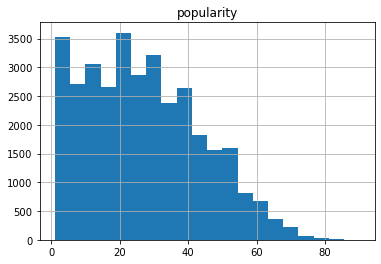

In [7]:
albums_less_than_three.hist(column='popularity', bins=20)

Not skewed, doesn't need to do log transformation

## 3. Word cloud of the artists

We found out most of the artists who have the largest number of songs are actually small-sized music producers. 

In [8]:
#!pip install wordcloud

In [9]:
import collections
from wordcloud import WordCloud, STOPWORDS

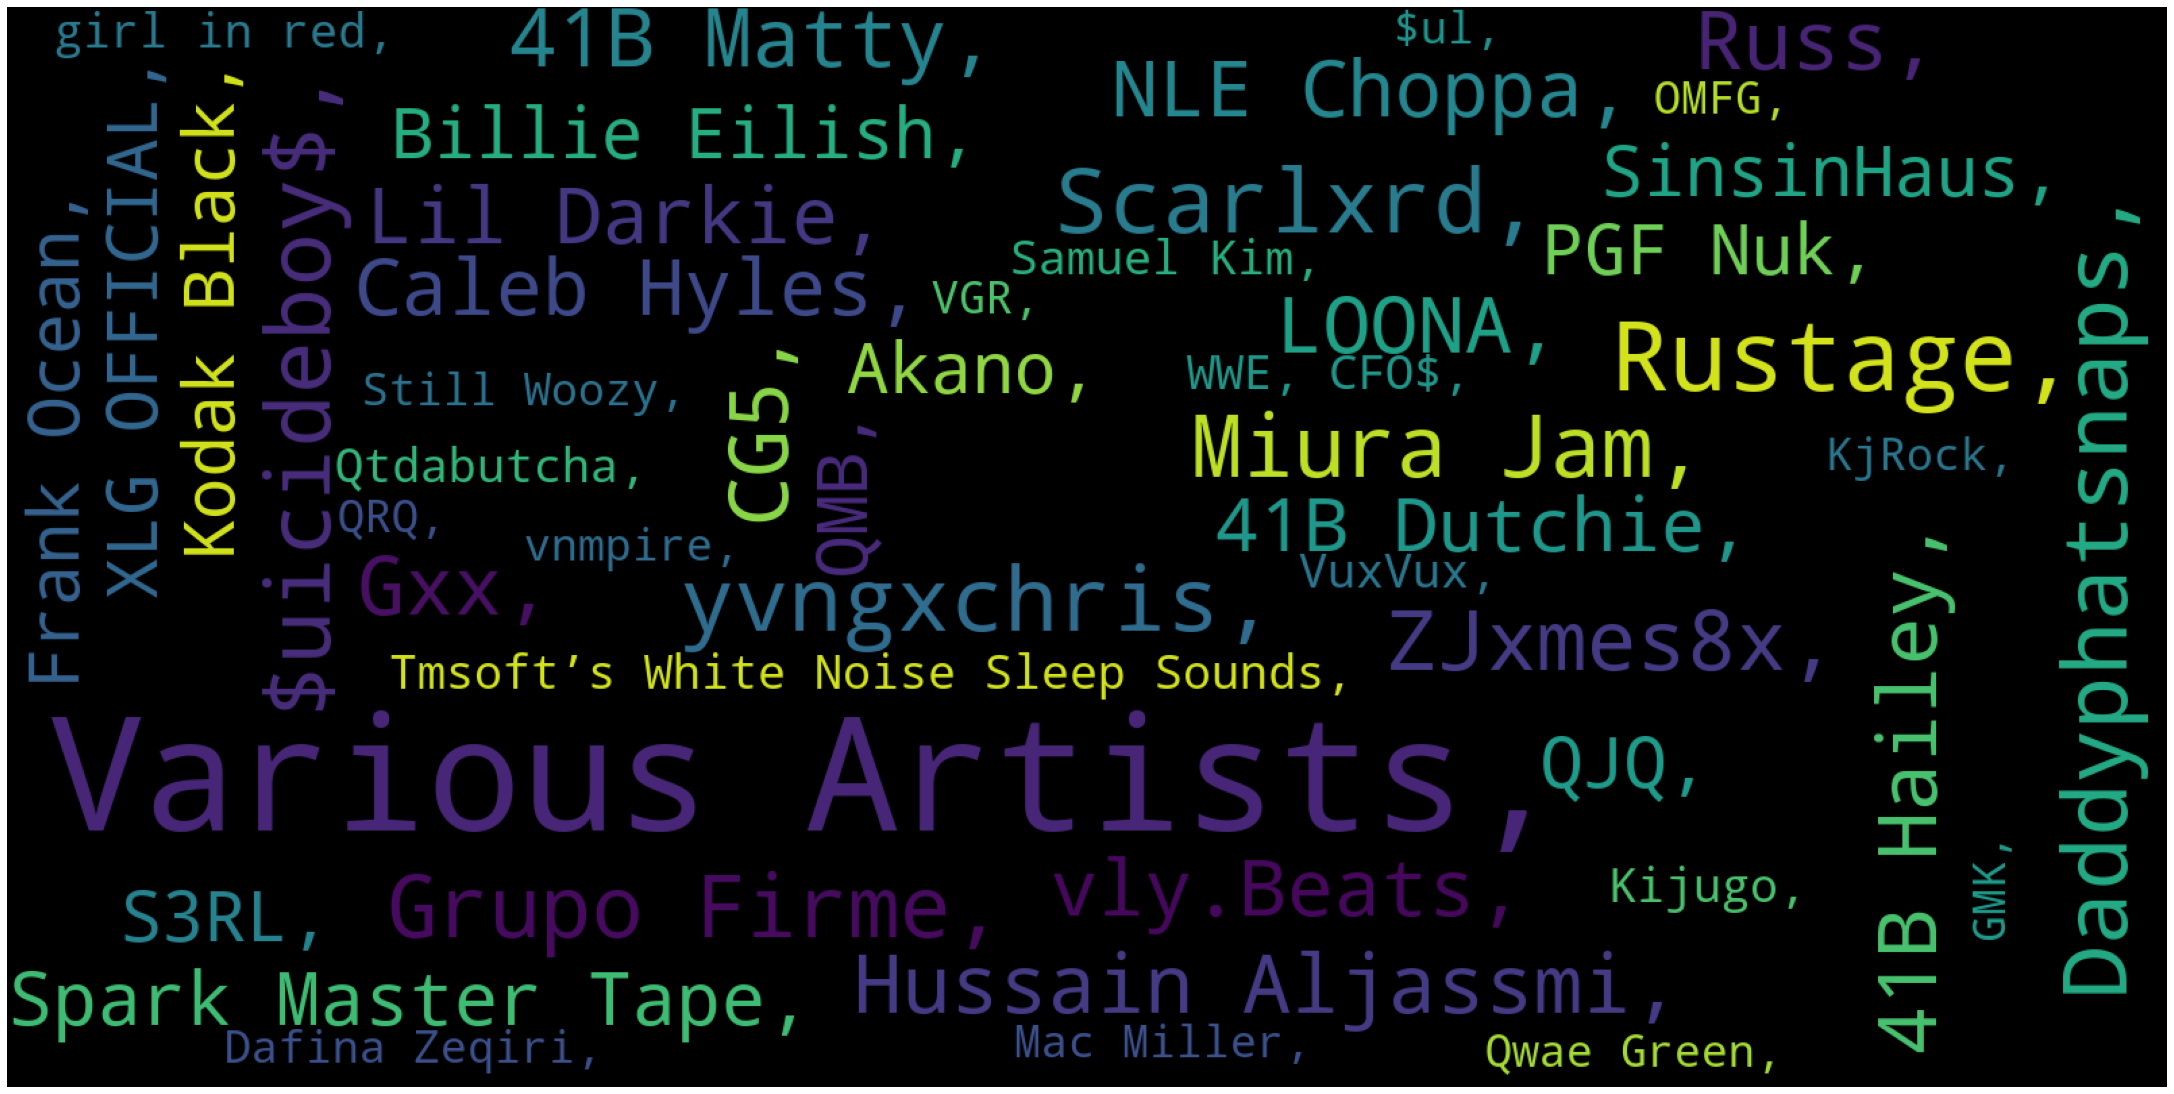

C:\Users\17008\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [10]:
# Visualizing a WordCloud of the most frequent artists
artists = []
    
# Obtaining the Frequency Distribution of artists
ctr = collections.Counter(albums_less_than_three['artists'])

# Selecting the 50 most common artists
dis_art = dict(ctr.most_common(50))

# Plotting the WordCloud
wordcloud = WordCloud(background_color = 'black', width = 1600, height = 800).generate_from_frequencies(dis_art)
fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

albums_less_than_three.set_index('name',inplace=True)
albums_less_than_three.drop(['artists'], axis=1, inplace=True)

In [11]:
print(dis_art)

{'Various Artists, ': 80, 'Rustage, ': 18, '$uicideboy$, ': 15, 'Daddyphatsnaps, ': 15, 'yvngxchris, ': 15, 'Scarlxrd, ': 15, 'Grupo Firme, ': 14, 'Miura Jam, ': 14, 'ZJxmes8x, ': 13, 'CG5, ': 12, 'Russ, ': 12, 'Gxx, ': 12, 'Hussain Aljassmi, ': 12, '41B Matty, ': 12, '41B Hailey, ': 12, 'NLE Choppa, ': 11, 'LOONA, ': 11, 'Lil Darkie, ': 11, 'vly.Beats, ': 11, 'Caleb Hyles, ': 11, 'Spark Master Tape, ': 11, '41B Dutchie, ': 11, 'SinsinHaus, ': 10, 'Frank Ocean, ': 10, 'Billie Eilish, ': 10, 'XLG OFFICIAL, ': 10, 'PGF Nuk, ': 10, 'QJQ, ': 10, 'Kodak Black, ': 10, 'S3RL, ': 10, 'QMB, ': 10, 'Akano, ': 10, 'Tmsoft’s White Noise Sleep Sounds, ': 9, 'girl in red, ': 9, 'Samuel Kim, ': 9, 'Qtdabutcha, ': 9, 'Kijugo, ': 9, 'WWE, CFO$, ': 9, 'VuxVux, ': 9, 'Qwae Green, ': 8, 'OMFG, ': 8, 'Mac Miller, ': 8, '$ul, ': 8, 'VGR, ': 8, 'GMK, ': 8, 'Dafina Zeqiri, ': 8, 'KjRock, ': 8, 'QRQ, ': 8, 'vnmpire, ': 8, 'Still Woozy, ': 8}


## 4. A quick scan of distrubution of all the other IVs

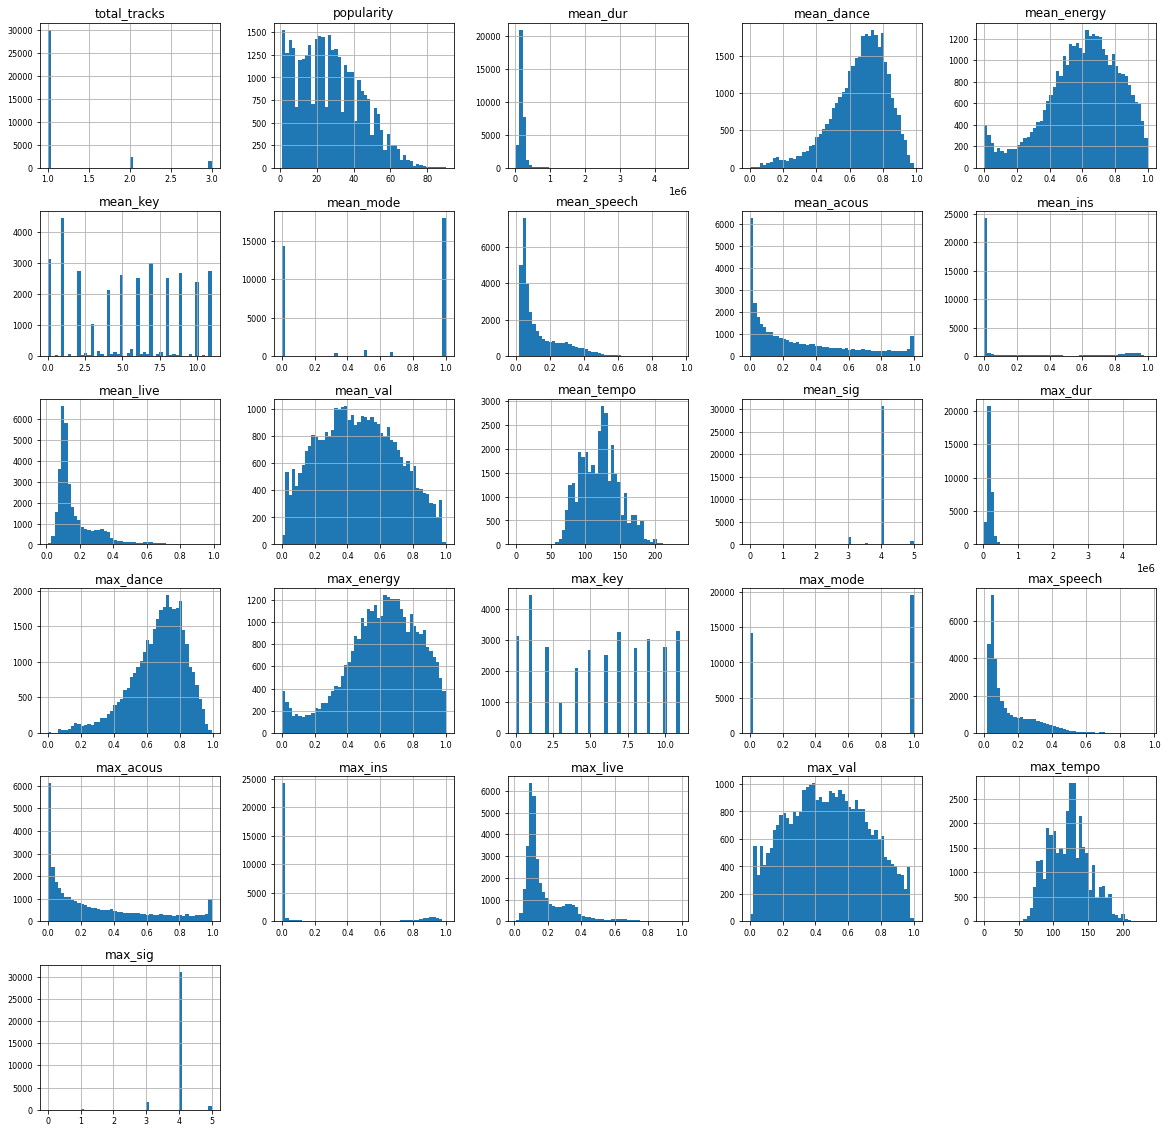

In [12]:
albums_less_than_three.hist(figsize = (20, 20), bins = 50, xlabelsize = 8, ylabelsize = 8);

## 5. The average popularity score of all the mini albums = 27 (pretty low, suprisingly)

In [13]:
average_popularity_of_mini_albums = np.average(albums_less_than_three["popularity"])
average_popularity_of_mini_albums

27.003222182807143

## 6. Test whether the average popularity score is statistically less than 50 using a  one-sides t-test?

In [14]:
t_stat, t_pval = stats.ttest_1samp(albums_less_than_three['popularity'], 50, alternative='less')
print('One-sided t-test result:')
print('t-statistic: %.3f'%t_stat)
print('p-value: %.3f'%t_pval)

One-sided t-test result:
t-statistic: -250.413
p-value: 0.000


H0: The average book price is no less than 50. 
Set a confidence level of 95%
Suppose that H0 is true, 
the probability that we are seeing such a test statistic at least as extreme as -32.680 is 0%.
Reject H0. 

**The average popularity score is statistically less than 50!!!**

The whole candle stick is on the left of x=50, indicating that the majority of the scores is less than 50


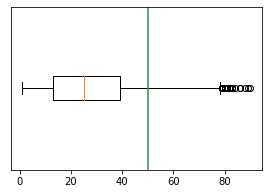

In [15]:
fig, ax = plt.subplots(figsize=[4.5, 3])

# set the boxplot to be horizontal
bplot = ax.boxplot(albums_less_than_three['popularity'], vert=False)

# to make it look better, we can remove the y ticks by giving the input as an empty list
_ = ax.set_yticks([])

# draw a line of x=50 for reference
indicative_50_line = ax.axvline(x=50, color='seagreen', label='reference (50)')

print("The whole candle stick is on the left of x=50, indicating that the majority of the scores is less than 50")

## 7. Pearson correlation between energy & danceability

In [16]:
corr_result = stats.pearsonr(albums_less_than_three["mean_dance"], albums_less_than_three["mean_energy"])
print(corr_result)

(0.17565653658758856, 1.5264254407488852e-232)


**There is a weak positive correlation between the average energy & dancability of a mini album (only 0.1756)**, with a p-value of 0.000 ( much smaller than 0.05, our confidence level), meaning that we should reject H0 (there's no the correlation between the two independent varriables.)

It aligns with our instinct, more energetic a song is, higher chance we would dance with it there will be.

## 8. Heatmap among album features (mean)

We want to highlight a medium-strong negative linear relationship (tested significant, don't worry) between average Energy level and average Acousticness. Acoustiness is opposed to electric. It pretty much makes sense. If a music or album is less acoustic (mpre electric), it usually has more energy. 

<AxesSubplot:>

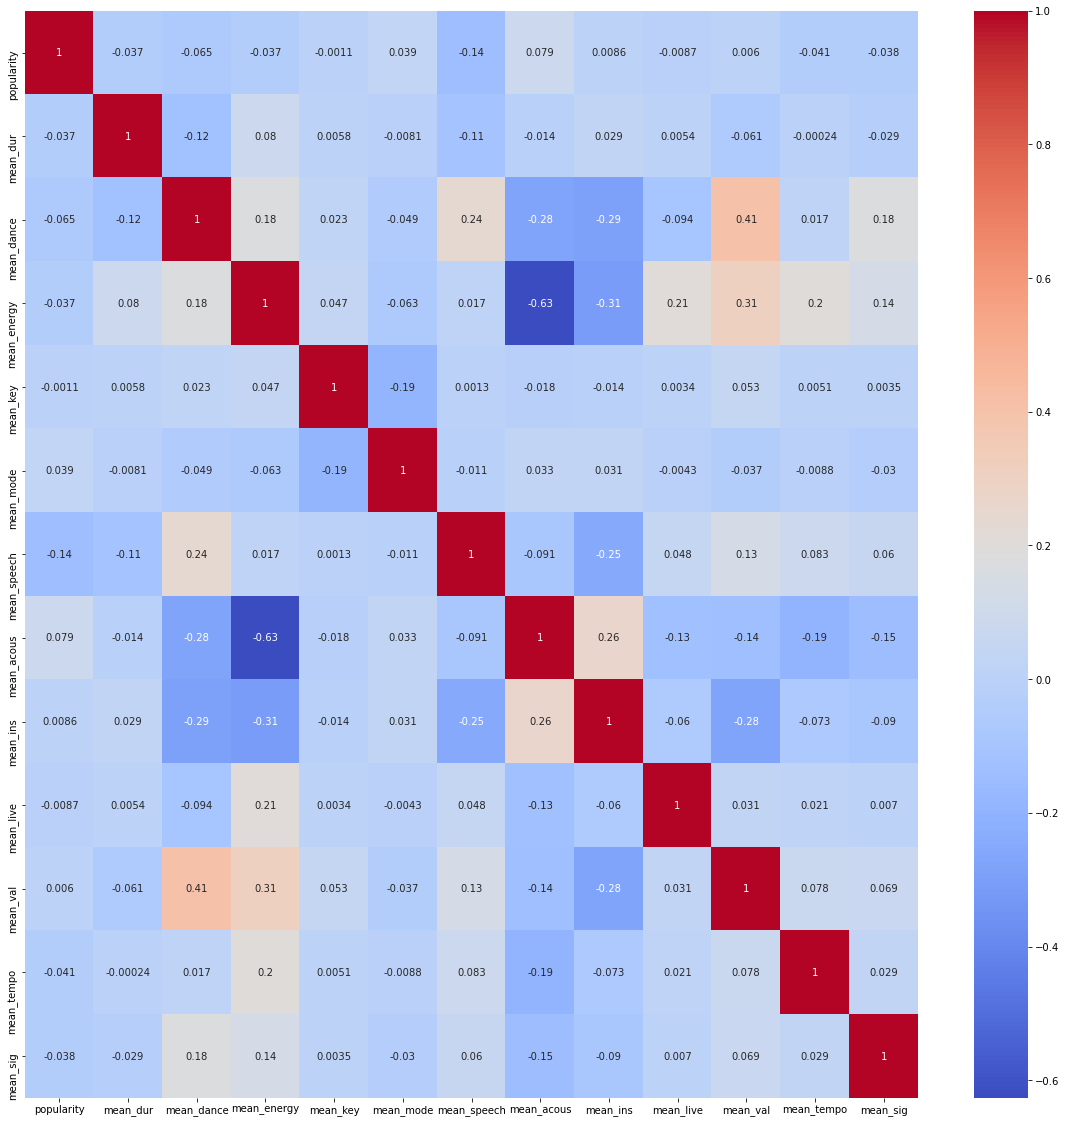

In [17]:
auto_df=albums_less_than_three[['popularity','mean_dur', 'mean_dance', 'mean_energy', 'mean_key', 'mean_mode', 'mean_speech', 'mean_acous', 'mean_ins', 'mean_live', 'mean_val', 'mean_tempo', 'mean_sig']]
fig, ax = plt.subplots(figsize=(20,20))  
sns.heatmap(auto_df.corr(), annot = True, fmt='.2g',cmap= 'coolwarm', ax = ax)

-----------------

# DATA ANALYSIS - Multiple Linear Regression

### Failed: Not significant at all :(

Yes, we are tring to predict the popularity scores of albums (a numeric variable). It's time for regression model! 

But neither the full-variable model nor step-wise reduced model provides a high R-square output or low MSE, and because many of the IVs are actually correlated, we spent loads of time to identify and deal with the multicollinearity problem. 

Thus, we are going to try something fancier, which may lead to a more significant model. 

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV
from sklearn.datasets import make_regression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import model_selection

In [19]:
# Archive of all feature columns
feature_cols = ['total_tracks', 'mean_dur', 'mean_dance', 'mean_energy',
       'mean_key', 'mean_mode', 'mean_speech', 'mean_acous', 'mean_ins',
       'mean_live', 'mean_val', 'mean_tempo', 'mean_sig', 'max_dur',
       'max_dance', 'max_energy', 'max_key', 'max_mode', 'max_speech',
       'max_acous', 'max_ins', 'max_live', 'max_val', 'max_tempo', 'max_sig']

In [20]:
# Reduced features
feature_cols = ['mean_mode',
        'mean_val', 'max_dur', 'max_speech',
       'max_acous', 'max_ins', 'max_live']
# the prediction target 
target_col = 'popularity'

In [21]:
# separate the feature (X) and target data (Y)
X = albums_less_than_three[feature_cols]
Y = albums_less_than_three[target_col]
print('Shape of X:', X.shape)
print('Size of Y:', Y.size)

Shape of X: (33828, 7)
Size of Y: 33828


**Apply VIF analysis on reducing unuseful variables to solve multicollinearity problem**

In [22]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,mean_mode,2.091737
1,mean_val,3.410487
2,max_dur,2.876672
3,max_speech,2.057202
4,max_acous,1.942356
5,max_ins,1.444526
6,max_live,2.400840


In [23]:
# split the dataset following our previous code
# let's jsut fix the number of test data to be 10k
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,
                                                                    Y,
                                                                    test_size=10000,
                                                                    random_state=626)
print('Training set:')
print('X: ', X_train.shape, 'Y:', Y_train.size)
print('Test set:')
print('X: ', X_test.shape, 'Y:', Y_test.size)

Training set:
X:  (23828, 7) Y: 23828
Test set:
X:  (10000, 7) Y: 10000


In [24]:
mlr = LinearRegression()
mlr.fit(X_train, Y_train)

print('Intercept: \n', mlr.intercept_)
print('Coefficients: \n', mlr.coef_)

# with statsmodels
X_train_constant = sm.add_constant(X_train) # adding a constant

model = sm.OLS(Y_train, X_train_constant).fit()
 
print_model = model.summary()
print(print_model)

Intercept: 
 28.359003540691113
Coefficients: 
 [ 1.09783548e+00  1.61895799e+00 -6.52545422e-06 -1.85078353e+01
  4.66851514e+00 -1.85939186e+00  1.36514442e+00]
                            OLS Regression Results                            
Dep. Variable:             popularity   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     106.7
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.73e-154
Time:                        19:29:42   Log-Likelihood:            -1.0085e+05
No. Observations:               23828   AIC:                         2.017e+05
Df Residuals:                   23820   BIC:                         2.018e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t    

In [25]:
y_pred_mlr= mlr.predict(X_test)
meanSqErr_mlr = metrics.mean_squared_error(Y_test, y_pred_mlr)
print('all feature','+','log_popularity')
print('R squared: {:.2f}%'.format(mlr.score(X_train,Y_train)*100))
print('Mean Square Error:', meanSqErr_mlr)

all feature + log_popularity
R squared: 3.04%
Mean Square Error: 274.8093860608453


-----------------------------------------------------

# DATA ANALYSIS - Elastic Net Cross Validation Linear Regression

### Failed: Nearly all IVs are wiped out (penalized), unfortunately :(

After seeing the unsatisfacting result of the "robust" step-wise-filtered multiple linear regression model, we dicided to try out the elastic net linear regression model with 5-fold cross validation to "intelligently" add in a penalty term and filter out the unwanted IVs. But it turned out everything was eliminated..., while the R-square is even lower (as you can imagine), which leads to our conclusion: linear regression models are definitely not suiable for this album popularity prediction problem. 

Thus, we are considering some other methods to gain some insights on it. 

In [26]:
# Elastic CV Regression
encv = ElasticNetCV(cv=5, random_state=0)
encv.fit(X_train, Y_train)

print('Intercept: \n', encv.intercept_)
print('Coefficients: \n', encv.coef_)
print('Alpha: \n', encv.alpha_)

y_pred_encv= encv.predict(X_test)
meanSqErr_encv = metrics.mean_squared_error(Y_test, y_pred_encv)
print('R squared: {:.2f}%'.format(encv.score(X_train,Y_train)*100))
print('Mean Square Error:', meanSqErr_encv)

Intercept: 
 27.93797465899997
Coefficients: 
 [ 0.00000000e+00  0.00000000e+00 -4.55652862e-06 -0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00]
Alpha: 
 9710.436116551888
R squared: 0.13%
Mean Square Error: 281.77065670831684


# DATA ANALYSIS - Decision Tree Regression

### Huge improvement! R-Square = 91.11%. But larger MSE

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
# Decision Tree Regression
dt_regr = DecisionTreeRegressor(ccp_alpha=0.01,random_state=626)

dt_regr.fit(X_train, Y_train)

# Predict
y_pred_dt_regr = dt_regr.predict(X_test)

meanSqErr_dt_regr = metrics.mean_squared_error(Y_test, y_pred_dt_regr)
print('R squared: {:.2f}%'.format(dt_regr.score(X_train,Y_train)*100))
print('Mean Square Error:', meanSqErr_dt_regr)

R squared: 90.20%
Mean Square Error: 501.84469588778603


### It looks like a pretty good model, but a bit conceptual, let's try something more instinctive. 

-----------------------------------------------------

# DATA ANALYSIS - Prepare New Y Variable for Classification Problem

## Change numerical Y variable to binary! "POPULAR" if popularity score > 50. 

It isn't that helpful to tell the popularity from a predicted numerical figure, since "popular" is the only thing that we concern, why don't we switch it to a binary variable, which might be easier to make predictions as well. 

So, the first step, let's define a song to be "popular" if its popularity score is higher than 50.(refer to our data exploration before)

[(0, 30383), (1, 3445)]
popular ratio =  0.10183871349178196
unpopular ratio =  0.898161286508218


<ipython-input-29-4339b414a83b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albums_less_than_three['popularity_binary'] = albums_less_than_three['popularity']>=51
<ipython-input-29-4339b414a83b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  albums_less_than_three['popularity_binary'] = albums_less_than_three['popularity_binary'].map({True:1, False:0})


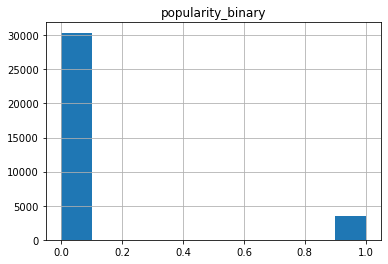

In [29]:
albums_less_than_three['popularity_binary'] = albums_less_than_three['popularity']>=51
albums_less_than_three['popularity_binary'] = albums_less_than_three['popularity_binary'].map({True:1, False:0})
albums_less_than_three.hist(column=['popularity_binary'])
wow = sorted(Counter(albums_less_than_three['popularity_binary']).items())
print(wow)
print("popular ratio = ",wow[1][1]/(wow[1][1]+wow[0][1]))
print("unpopular ratio = ",wow[0][1]/(wow[1][1]+wow[0][1]))

We created a super inbalanced dataset. Let's do oversampling later.

-----------------------------------------------------

# DATA ANALYSIS - Logistic Regression

### Terrible *Pseudo R-square* (0.039), low *F1 score* (0.18)

In [30]:
feature_cols = ['total_tracks', 'mean_dur', 'mean_dance', 'mean_energy',
       'mean_key', 'mean_mode', 'mean_speech', 'mean_acous', 'mean_ins',
       'mean_live', 'mean_val', 'mean_tempo', 'mean_sig', 'max_dur',
       'max_dance', 'max_energy', 'max_key', 'max_mode', 'max_speech',
       'max_acous', 'max_ins', 'max_live', 'max_val', 'max_tempo', 'max_sig']
# the prediction target 
target_col = 'popularity_binary'

In [31]:
# separate the feature (X) and target data (Y)
X = albums_less_than_three[feature_cols]
Y = albums_less_than_three[target_col]
print('Shape of X:', X.shape)
print('Size of Y:', Y.size)

Shape of X: (33828, 25)
Size of Y: 33828


In [32]:
#pip install imblearn

In [33]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

In [34]:
# split the dataset following our previous code
# let's jsut fix the number of test data to be 10k
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X,
                                                                    Y,
                                                                    test_size=10000,
                                                                    random_state=626)
print('Training set:')
print('X: ', X_train.shape, 'Y:', Y_train.size)
print('Test set:')
print('X: ', X_test.shape, 'Y:', Y_test.size)

Training set:
X:  (23828, 25) Y: 23828
Test set:
X:  (10000, 25) Y: 10000


In [36]:
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

print(sorted(Counter(Y_train).items()))

[(0, 21383), (1, 21383)]


In [38]:
from sklearn.linear_model import LogisticRegression

In [39]:
import statsmodels.api as sm
logit_model=sm.Logit(Y_train,X_train)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.666465
         Iterations 6
                          Results: Logit
Model:              Logit             Pseudo R-squared: 0.038     
Dependent Variable: popularity_binary AIC:              57054.0620
Date:               2022-11-26 19:30  BIC:              57270.6494
No. Observations:   42766             Log-Likelihood:   -28502.   
Df Model:           24                LL-Null:          -29643.   
Df Residuals:       42741             LLR p-value:      0.0000    
Converged:          1.0000            Scale:            1.0000    
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
total_tracks  -0.5848    0.0556  -10.5122  0.0000  -0.6938  -0.4757
mean_dur       0.0000    0.0000    2.7319  0.0063

In [40]:
# Train Regressor
logit = LogisticRegression(random_state=626).fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_logit = logit.predict(X_test)


print('Accuracy: ', logit.score(X_test, Y_test),'\n')
print(confusion_matrix(Y_test, y_pred_logit))
print(classification_report(Y_test, y_pred_logit))

Accuracy:  0.1794 

[[ 894 8106]
 [ 100  900]]
              precision    recall  f1-score   support

           0       0.90      0.10      0.18      9000
           1       0.10      0.90      0.18      1000

    accuracy                           0.18     10000
   macro avg       0.50      0.50      0.18     10000
weighted avg       0.82      0.18      0.18     10000



-----------------------------------------------------

# DATA ANALYSIS - Pruned Decision Tree

### Doesn't work at all!!!!! It just took a random guess of "unpopular"! 

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [42]:
# Create Decision Tree classifer object
dt_prune = DecisionTreeClassifier(ccp_alpha=0.01, random_state=626)

# Train Classifer
dt_prune = dt_prune.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_dt_prune = dt_prune.predict(X_test)
meanSqErr_dt_prune = metrics.mean_squared_error(Y_test, y_pred_dt_prune)
print('Mean Square Error:', meanSqErr_dt_prune)

print('Accuracy: ', dt_prune.score(X_test, Y_test))
print(confusion_matrix(Y_test, y_pred_dt_prune))
print(classification_report(Y_test, y_pred_dt_prune))

Mean Square Error: 0.1
Accuracy:  0.9
[[9000    0]
 [1000    0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9000
           1       0.00      0.00      0.00      1000

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



C:\Users\17008\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\17008\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\17008\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


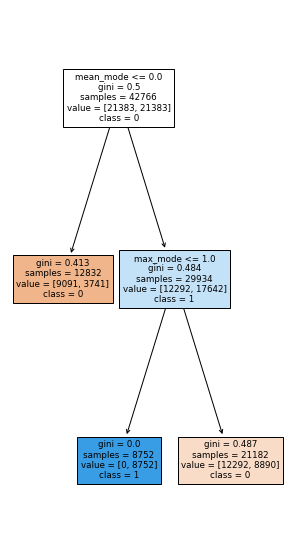

In [43]:
fig = plt.figure(figsize=(5,10))
_ = tree.plot_tree(dt_prune, 
                   feature_names=X.columns,  
                   class_names=["0","1"],
                   filled=True)

-----------------------------------------------------

# DATA ANALYSIS - Random Forest

### Best of all! Highest *F1 score* (0.19), but still not quite useful

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [45]:
# Create Decision Tree classifer object
random_forest = RandomForestClassifier(max_depth=2, random_state=626)

# Train Classifer
random_forest = random_forest.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_random_forest = random_forest.predict(X_test)

print(random_forest)
print('Accuracy: ', random_forest.score(X_test, Y_test))
print(confusion_matrix(Y_test, y_pred_random_forest))
print(classification_report(Y_test, y_pred_random_forest))

RandomForestClassifier(max_depth=2, random_state=626)
Accuracy:  0.6592
[[6189 2811]
 [ 597  403]]
              precision    recall  f1-score   support

           0       0.91      0.69      0.78      9000
           1       0.13      0.40      0.19      1000

    accuracy                           0.66     10000
   macro avg       0.52      0.55      0.49     10000
weighted avg       0.83      0.66      0.72     10000



-----------------------------------------------------

# DATA ANALYSIS - GRADIENT BOOSTING

### Only a bit outperformed the wild guess. With recall = 0.04, and f1-score = 0.06

In [46]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
#creating Scoring parameter: 
scoring = {'accuracy': make_scorer(accuracy_score),'f1':make_scorer(f1_score),
           'precision': make_scorer(precision_score),'recall':make_scorer(recall_score)}

In [47]:
# Create GB classifer object
gbm = GradientBoostingClassifier(learning_rate=0.01, random_state=626)

# Train Classifer
gbm = gbm.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_gbm = gbm.predict(X_test)
meanSqErr_gbm = metrics.mean_squared_error(Y_test, y_pred_gbm)
print('Mean Square Error:', meanSqErr_gbm)

print('Accuracy: ', gbm.score(X_test, Y_test))
print(confusion_matrix(Y_test, y_pred_gbm))
print(classification_report(Y_test, y_pred_gbm))

Mean Square Error: 0.116
Accuracy:  0.884
[[8805  195]
 [ 965   35]]
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      9000
           1       0.15      0.04      0.06      1000

    accuracy                           0.88     10000
   macro avg       0.53      0.51      0.50     10000
weighted avg       0.83      0.88      0.85     10000



We tried to perform grid search to find the optimal parameter combination, but failed as it cost too much time

In [ ]:
# Grid for grid search parameter tuning 
parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_leaf":[7,10,12,15],
    "max_depth":[4,5,6,7,8]
    }

In [ ]:
#passing the scoring function in the GridSearchCV
gbm = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

gbm.fit(X_train, Y_train)
#converting the clf.cv_results to dataframe
df=pd.DataFrame.from_dict(gbm.cv_results_)
#here Possible inputs for cross validation is cv=2, there two split split0 and split1
df[['split0_test_accuracy','split1_test_accuracy','split0_test_precision','split1_test_precision','split0_test_recall','split1_test_recall']]

-----------------------------------------------------

# DATA ANALYSIS - Basic Neural Network

### What a "intelligent" model! 

Well, the model just takes a different wild guess of "popular", to achive a 100% recall score. But it is not insightful at all (f1-score = 0.18), and advanced ML models like neural network always cost SO MUCH TIME! 

In [48]:
#pip install --upgrade tensorflow
#pip install keras

In [49]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder

In [50]:
# One Hot encode the class labels
encoder = OneHotEncoder(sparse=False)
Y_train_encoded = encoder.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_encoded = encoder.fit_transform(Y_test.values.reshape(-1, 1))

In [51]:
# one hot encode outputs
from keras.utils import to_categorical 
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

count_classes = Y_test.shape[1]
print(count_classes)

2


In [52]:
model = Sequential()

model.add(Dense(10, input_shape=(25,), activation='relu', name='h1')) # hidden layer, 10 nodes, 25 input nodes
model.add(Dense(10, activation='relu', name='h2')) # hidden layer, 10 nodes
model.add(Dense(2, activation='softmax', name='output')) # output layer, 2 output nodes

# Adam optimizer with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

print('Neural Network Model Summary: ')
print(model.summary())

Neural Network Model Summary: 
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 h1 (Dense)                  (None, 10)                260       
                                                                 
 h2 (Dense)                  (None, 10)                110       
                                                                 
 output (Dense)              (None, 2)                 22        
                                                                 
Total params: 392
Trainable params: 392
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
model.fit(X_train, Y_train, verbose=3, batch_size=5, epochs=1000)

Epoch 1/1000
Epoch 2/1000
Epoch 3/1000
Epoch 4/1000
Epoch 5/1000
Epoch 6/1000
Epoch 7/1000
Epoch 8/1000
Epoch 9/1000
Epoch 10/1000
Epoch 11/1000
Epoch 12/1000
Epoch 13/1000
Epoch 14/1000
Epoch 15/1000
Epoch 16/1000
Epoch 17/1000
Epoch 18/1000
Epoch 19/1000
Epoch 20/1000
Epoch 21/1000
Epoch 22/1000
Epoch 23/1000
Epoch 24/1000
Epoch 25/1000
Epoch 26/1000
Epoch 27/1000
Epoch 28/1000
Epoch 29/1000
Epoch 30/1000
Epoch 31/1000
Epoch 32/1000
Epoch 33/1000
Epoch 34/1000
Epoch 35/1000
Epoch 36/1000
Epoch 37/1000
Epoch 38/1000
Epoch 39/1000
Epoch 40/1000
Epoch 41/1000
Epoch 42/1000
Epoch 43/1000
Epoch 44/1000
Epoch 45/1000
Epoch 46/1000
Epoch 47/1000
Epoch 48/1000
Epoch 49/1000
Epoch 50/1000
Epoch 51/1000
Epoch 52/1000
Epoch 53/1000
Epoch 54/1000
Epoch 55/1000
Epoch 56/1000
Epoch 57/1000
Epoch 58/1000
Epoch 59/1000
Epoch 60/1000
Epoch 61/1000
Epoch 62/1000
Epoch 63/1000
Epoch 64/1000
Epoch 65/1000
Epoch 66/1000
Epoch 67/1000
Epoch 68/1000
Epoch 69/1000
Epoch 70/1000
Epoch 71/1000
Epoch 72/1000
E

Epoch 555/1000
Epoch 556/1000
Epoch 557/1000
Epoch 558/1000
Epoch 559/1000
Epoch 560/1000
Epoch 561/1000
Epoch 562/1000
Epoch 563/1000
Epoch 564/1000
Epoch 565/1000
Epoch 566/1000
Epoch 567/1000
Epoch 568/1000
Epoch 569/1000
Epoch 570/1000
Epoch 571/1000
Epoch 572/1000
Epoch 573/1000
Epoch 574/1000
Epoch 575/1000
Epoch 576/1000
Epoch 577/1000
Epoch 578/1000
Epoch 579/1000
Epoch 580/1000
Epoch 581/1000
Epoch 582/1000
Epoch 583/1000
Epoch 584/1000
Epoch 585/1000
Epoch 586/1000
Epoch 587/1000
Epoch 588/1000
Epoch 589/1000
Epoch 590/1000
Epoch 591/1000
Epoch 592/1000
Epoch 593/1000
Epoch 594/1000
Epoch 595/1000
Epoch 596/1000
Epoch 597/1000
Epoch 598/1000
Epoch 599/1000
Epoch 600/1000
Epoch 601/1000
Epoch 602/1000
Epoch 603/1000
Epoch 604/1000
Epoch 605/1000
Epoch 606/1000
Epoch 607/1000
Epoch 608/1000
Epoch 609/1000
Epoch 610/1000
Epoch 611/1000
Epoch 612/1000
Epoch 613/1000
Epoch 614/1000
Epoch 615/1000
Epoch 616/1000
Epoch 617/1000
Epoch 618/1000
Epoch 619/1000
Epoch 620/1000
Epoch 621/

In [54]:
#Predict the response for test dataset
y_pred_nt = model.predict(X_test)

y_prediction = np.argmax (y_pred_nt, axis = 1)
y_test=np.argmax(Y_test, axis=1)
print(confusion_matrix(y_test, y_prediction))
print(classification_report(y_test, y_prediction))

313/313 [==============================] - 1s 671us/step
[[9000    0]
 [1000    0]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      9000
           1       0.00      0.00      0.00      1000

    accuracy                           0.90     10000
   macro avg       0.45      0.50      0.47     10000
weighted avg       0.81      0.90      0.85     10000



C:\Users\17008\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\17008\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\17008\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CONCLUSION

1. There're lots of **fun facts** we could find through data exploration. For instance, correlation between variables, top albums on the globe, distribution & average of certain variables, etc. 
2. If our clients (spotify or record companies) want to make predicitons to the popularity of the latest mini albums, we recommend they could delopy our **random forest classification model**, since it has the best performance, and could **identify 40% of the POPULAR** albums wit fewer wrong guesses. But to be honest, it's **not that useful.** 
3. There's still a long way to go before achieve a good model. It's probably because: <br>
    a. **The popularity score is always changing**, even the top album *Stay* by Justin Bieber may not be popular any more 2 years later. So, the **REAL popularity of the albums should be determined by the score soon after the release date**, but there's no way for us to get the data anymore. <br> 
    b. The IVs in the dataset are not good estimators indeed to pretict popularity<br>
    c. Only look at the albums with max. three songs may create bias, which results to a not satisfying model <br>
    d. The parameters we're using in the ML models may not be the optimal one. <br>
4. **Finally, if we zoom out and take a step back to look at the problem as a whole, we will find that the project actually focuses on people's subjective preference, but that will be absolutely difficult as human is the most sophisticated creature on the globe, everything related to human behavior usually comes with randomness, stochasticity, confusion, and chaos.**